# Project Information

The objective is to distinguish between several diseases that cause material harm to the food supply of many African countries. In some cases the main remedy is to burn the infected plants to prevent further spread, which can make a rapid automated turnaround quite useful to the farmers.

[train/test]_images the image files. The full set of test images will only be available to your notebook when it is submitted for scoring. Expect to see roughly 15,000 images in the test set.

### Attributes

image_id -  image file name.

label - ID code for the disease.

label_num_to_disease_map.json - The mapping between each disease code and the real disease name.


**Download link:** https://www.kaggle.com/c/cassava-leaf-disease-classification/data

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import time
import os
import copy
import json

# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms

# augmentation
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c cassava-leaf-disease-classification

100% 5.74G/5.76G [00:28<00:00, 248MB/s]
100% 5.76G/5.76G [00:28<00:00, 217MB/s]


In [8]:
! unzip cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

## Load the Dataset

In [11]:
# BASE_DIR = "/content/cassava-leaf-disease-classification/"

train = pd.read_csv('/content/train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [12]:
# loading mapping for target label
with open('/content/label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}
mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [13]:
train['label_names'] = train['label'].map(mapping)
train.head()

image_id  label                          label_names
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

## Exploratory Data Analysis

In [17]:
def plot_images(class_id, label, total_images=6):
    # get image ids corresponding to the target class id
    plot_list = train[train['label']==class_id].sample(total_images)['image_id'].tolist()
    
    labels = [label for i in range(total_images)]
    # dynamically set size for subplot
    size = int(np.sqrt(total_images))
    if size*size < total_images:
        size += 1
    
    # set figure size
    plt.figure(figsize=(15,15))
    
    # plot the image in subplot
    for index, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, index+1)
        image = Image.open(str('train_images/' + image_id))
        plt.imshow(image)
        plt.title(label, fontsize=14)
        plt.axis('off')
        
    plt.show()

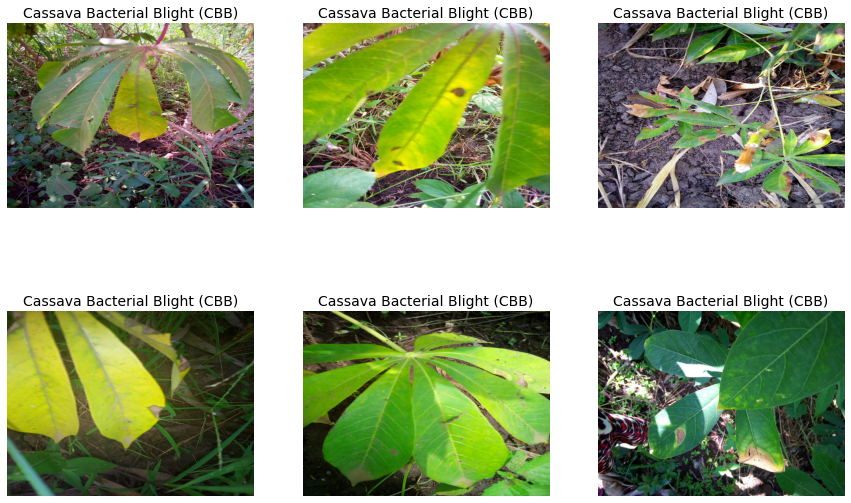

In [18]:
plot_images(0, mapping[0], 6)

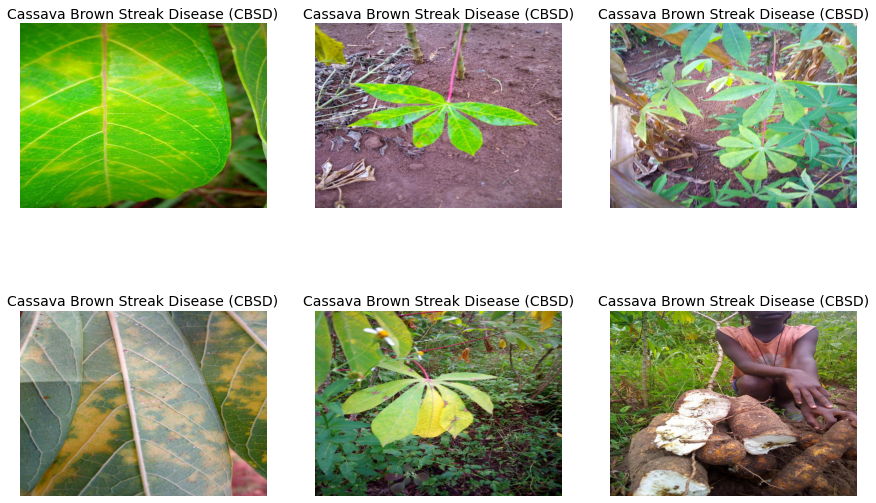

In [19]:
plot_images(1, mapping[1], 6)

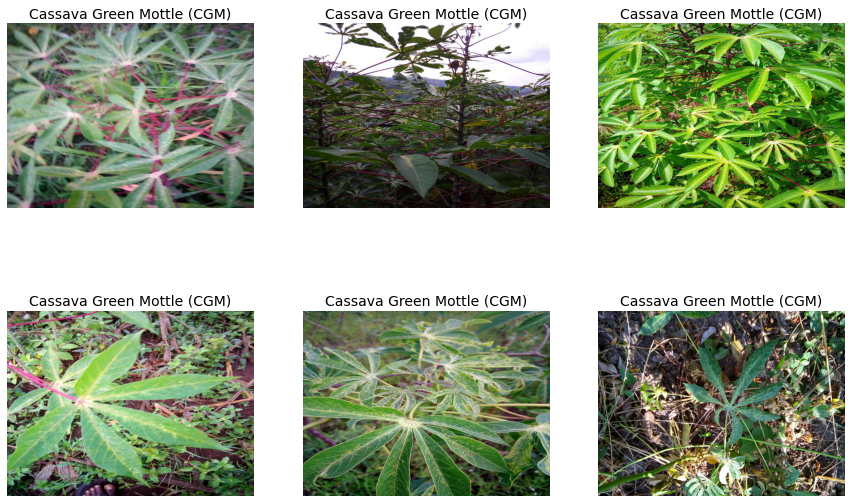

In [20]:
plot_images(2, mapping[2], 6)

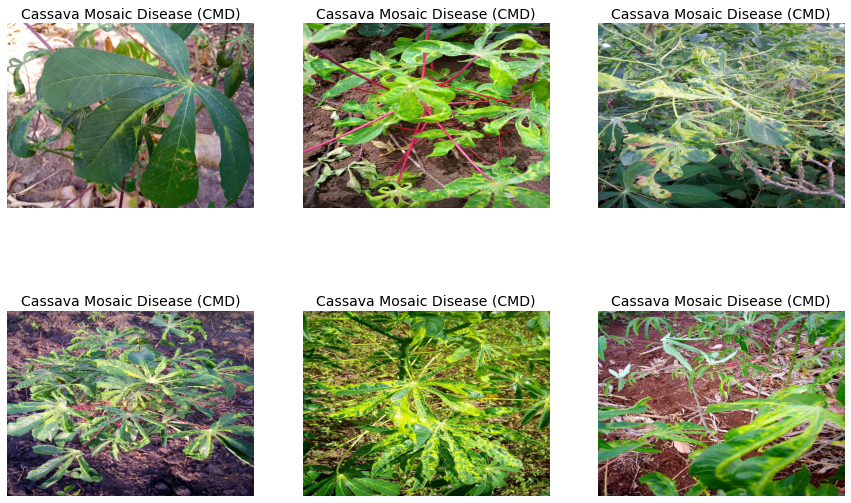

In [21]:
plot_images(3, mapping[3], 6)

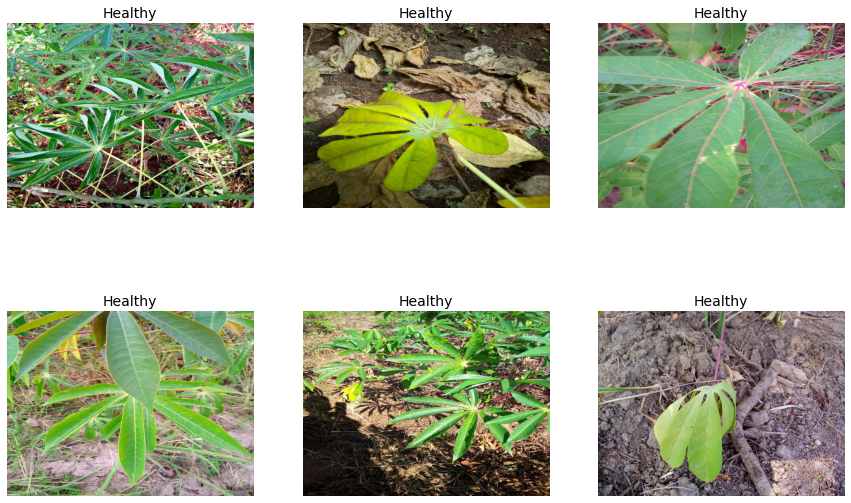

In [22]:
plot_images(4, mapping[4], 6)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

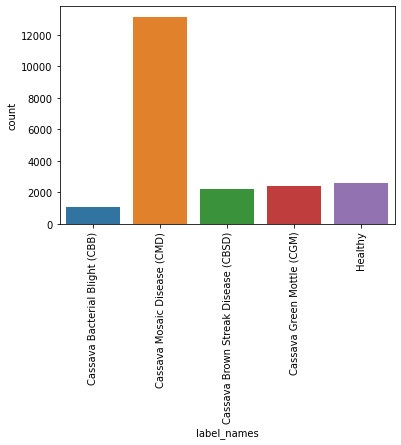

In [23]:
# class distribution
sns.countplot(train['label_names'])
plt.xticks(rotation=90)

## Configuration and Utility Functions

In [24]:
DIM = (256, 256)
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
NUM_WORKERS = 24
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
SEED = 1

DEVICE = 'cuda'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## Augmentations

In [25]:
def get_test_transforms(value = 'val'):
    if value == 'train':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])
    elif value == 'val':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])

## Dataset Loader Class

In [33]:
class CassavaDataset(Dataset):
    def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='/content/train_images'):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.dim = dimension
        self.augmentations = augmentations
        self.folder = folder
    
    # returns the length
    def __len__(self):
        return len(self.image_ids)
    
    # return the image and label for that index
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.folder, self.image_ids[idx]))
        
        if self.dim:
            img = img.resize(self.dim)
        
        # convert to numpy array
        img = np.array(img)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

## Train Test Split

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)

In [35]:
from torch.utils.data import WeightedRandomSampler
def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)
    print('Unique Labels', label_unique)
    weights = [sum(counts) / c for c in counts]
    sample_weights = [weights[w] for w in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [36]:
train_sampler = sampler_(y_train)

Unique Labels [0 1 2 3 4]


In [37]:
# create dataloaders for training antrain_test_splitidation
train_dataset = CassavaDataset(
    image_ids=x_train.values,
    labels=y_train.values,
    augmentations=get_test_transforms('train'),
    dimension=DIM
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    sampler=train_sampler
)

val_dataset = CassavaDataset(
    image_ids=x_test.values,
    labels=y_test.values,
    augmentations=get_test_transforms('val'),
    dimension=DIM
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

loaders = {'train': train_loader, 'val': val_loader}

In [38]:
# to check whether dataset is working or not
# fetch the data based on index
val_dataset[0]

(tensor([[[-0.2856,  0.0569,  0.3652,  ...,  0.4508,  0.2453,  0.4508],
          [-0.5767, -0.0629,  0.1254,  ..., -0.0458, -0.2342,  0.1768],
          [-0.8507, -0.6109, -0.9877,  ..., -0.6109, -0.2513,  0.0569],
          ...,
          [-0.1486, -0.4568, -0.8678,  ...,  0.1426,  0.2453,  0.3823],
          [-0.9363, -1.2103, -1.2445,  ...,  0.5536,  0.7591,  0.8789],
          [-1.4329, -1.4329, -1.3987,  ...,  0.8104,  1.0673,  1.1872]],
 
         [[-0.0924,  0.3277,  0.6779,  ...,  1.2381,  0.9055,  0.8704],
          [-0.1625,  0.4153,  0.6604,  ...,  0.7129,  0.3978,  0.6254],
          [-0.1099,  0.1352, -0.1800,  ...,  0.1001,  0.3978,  0.5203],
          ...,
          [ 0.3102, -0.0049, -0.4251,  ...,  0.9405,  1.0280,  1.1331],
          [-0.4426, -0.7052, -0.7227,  ...,  1.2556,  1.3782,  1.4307],
          [-0.8803, -0.8627, -0.7752,  ...,  1.4482,  1.5532,  1.5707]],
 
         [[-1.3687, -1.3861, -1.3687,  ...,  0.6879,  0.3219,  0.6182],
          [-1.5430, -1.1944,

## Use Pretrained Model (Transfer Learning)

In [39]:
def getModel():
    net = models.resnet152(pretrained=True)
    
    # if you want to train the whole network, comment this code
    # freeze all the layers in the network
    for param in net.parameters():
        param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    # create last few layers
    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, NUM_CLASSES),
        nn.LogSoftmax(dim=1)
    )
    
    # use gpu if any
    net = net.cuda() if DEVICE else net
    return net

In [40]:
model = getModel()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [41]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [42]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)
step_size = 4*len(train_loader)
clr = cyclical_lr(step_size, min_lr=3e-4, max_lr=3e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [44]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
# freeze (or) unfreeze all the layers
unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze

In [46]:
# find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')

58,669,637 total parameters
58,669,637 training parameters


## Steps for Training and Validation

In [47]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, scheduler=scheduler):
    # set starting time
    start_time = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*15)
        
        # each epoch have training and validation phase
        for phase in ['train', 'val']:
            # set mode for model
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            fin_out = []
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to corresponding hardware
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                # reset (or) zero the parameter gradients
                optimizer.zero_grad()
                
                # training (or) validation process
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # back propagation in the network
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # calculate loss and accuarcy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # print loss and acc for training & validation
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # update the best weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
        print()
    end_time = time.time() - start_time
    
    print('Training completes in {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [48]:
# train the model
model, accuracy = train_model(model=model, dataloaders=loaders, criterion=criterion, optimizer=optimizer, num_epochs=5, scheduler=scheduler)

Epoch 0/4
---------------
train Loss: 1.2211 Acc: 0.5156
val Loss: 0.7097 Acc: 0.7428

Epoch 1/4
---------------
train Loss: 0.7239 Acc: 0.7364
val Loss: 0.5260 Acc: 0.8204

Epoch 2/4
---------------
train Loss: 0.6013 Acc: 0.7807
val Loss: 0.5803 Acc: 0.8032

Epoch 3/4
---------------
train Loss: 0.5499 Acc: 0.7983
val Loss: 0.6507 Acc: 0.7710

Epoch 4/4
---------------
train Loss: 0.5003 Acc: 0.8210
val Loss: 0.6393 Acc: 0.7979

Training completes in 45m 25s
Best Val Acc: 0.8204


In [49]:
# save the model and model weights
#torch.save(model, '...best_model.h5')
#torch.save(model.state_dict(), '...best_model_weights')

In [50]:
# freeze (or) unfreeze all the layers
unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze

In [51]:
# # unfreeze seleected layers
# layers = list(range(5,7))
# i = 0
# for layer in model.children():
#     if i in layers:
#         for param in layer.parameters():
#             param.requires_grad = True
#     i += 1

In [52]:
# find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')

58,669,637 total parameters
58,669,637 training parameters


In [ ]:
# # gives the number of layers
# for i,layer in enumerate(model.children()):
#     print(i)

## Testing the Model

In [53]:
# empty the cache from cuda device
torch.cuda.empty_cache()

In [54]:
def predict(model, dataloader, device):
    # set mode to eval
    model.eval()
    fin_out = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            
            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())
            
    return np.concatenate(fin_out)

In [55]:
# steps for model prediction
device = torch.device('cuda') # if you don't have gpu, set it as cpu
model.to(device)
pred = predict(model, val_loader, device)
pred = pred.argmax(axis=1)

In [56]:
y_test.values[:5]

array([3, 3, 3, 3, 1])

In [57]:
pred[:5]

array([3, 3, 3, 3, 1])